# Notebook Regresion Lineal 2 Reto: Interlub
Author: A. Ramirez-Morales (andres.ramirez@tec.mx)


## Instrucciones:
- Active su entorno de `conda`
- Complete las funciones donde vea líneas de código inconclusas
- Use comentarios para documentar de manera integral sus funciones
- Pruebe sus funciones con distintos parámetros
- Aumente las explicaciones en el Markdown y en el código

In [12]:
# cargar librerías básicas
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro
import pandas as pd

# 1. Base de datos numerica
*Ejercicio:* Cargue los datos previamente preparados 100% numericos

In [13]:
df = pd.read_csv("../../datos/datos_grasas_Tec_limpio_num.csv")

In [14]:
df = df.astype(float)

## 2. Generacion de datos mas avanzada

### 2.1. Simulacion mediante KNN 

*Ejercicio:* Agregar explicacion detallada del algoritmo y de la funcion

In [15]:
def simular_datos_knn(df_original, n_nuevos=100, k=5):
    """
    documentar
    """
    X = df_original.to_numpy(dtype=float)

    # normalizaicion basica
    n, d = X.shape
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    Xn = (X - mean) / std

    nuevos = []
    for _ in range(n_nuevos):
        base = Xn[np.random.randint(0, n)]               # 1
        dist = np.sqrt(np.sum((Xn - base) ** 2, axis=1)) # 2
        vecinos_idx = np.argsort(dist)[1:k+1]            # 3
        vecino = Xn[np.random.choice(vecinos_idx)]       # 4
        nuevo = base + np.random.rand() *(vecino - base) # 5
        nuevos.append(nuevo)

    nuevos = np.array(nuevos)
    # quitar norm,.
    X_new = nuevos * std + mean

    df_nuevo = pd.DataFrame(X_new, columns=df_original.columns)
    return df_nuevo


### 2.2. Simulacion mediante Gaussian Copulas

Ejercicios:
- Describa para que nos sirven las copulas gaussianas
- Revise la documentacion https://sdv.dev/Copulas/
- Encuentre que funciones podrian mejorar la funcionalidad en la funcion que escribio el profesor abajo


In [16]:
from copulas.multivariate import GaussianMultivariate
import pandas as pd

def simular_datos_copula(df_original, n_nuevos=100):
    """
    escriba documentacion adecuada
    """
    model = GaussianMultivariate()
    model.fit(df_original)
    df_nuevo = model.sample(n_nuevos)
    return df_nuevo

### 2.3. Simulacion con Variational AutoEncoder 

Los VAE aprenden un espacio latente continuo del cual se puede muestrear.

Muy útiles si tus datos tienen una estructura suave (por ejemplo, mediciones físicas).

In [17]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        mu_logvar = self.encoder(x)
        mu, logvar = mu_logvar.chunk(2, dim=-1)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


def simular_datos_vae(df_original, n_nuevos=100, latent_dim=5, epochs=500, lr=1e-4):
    """
    documentar
    """
    df_num = df_original.select_dtypes(include=np.number).replace(-99, np.nan)
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values

    # comentar
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    X_norm = (X - mean) / std

    # comentar
    X_tensor = torch.tensor(X_norm, dtype=torch.float32)

    vae = VAE(input_dim=X.shape[1], latent_dim=latent_dim)
    # comentar
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    def loss_fn(recon_x, x, mu, logvar):
        recon_loss = nn.functional.mse_loss(recon_x, x) # comentar
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) # comentar
        return recon_loss + kl_loss

    for epoch in range(epochs):
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(X_tensor)
        loss = loss_fn(recon_x, X_tensor, mu, logvar)
        loss.backward()
        optimizer.step()

        if torch.isnan(loss):
            break

    # generacion de datos
    with torch.no_grad():
        z = torch.randn(n_nuevos, latent_dim)
        X_new_norm = vae.decoder(z).numpy()

    # quitar la norm,.
    X_new = X_new_norm * std + mean
    return pd.DataFrame(X_new, columns=df_num.columns)


# 3. Regresión lineal

### 3.1 Definir, probar el modelo y graficar resultados

c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:6738: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\GustavoAguilar\anaconda3\envs\movie-reco\Lib\site-packages\scipy\stats\_continuous_distns.py:801:

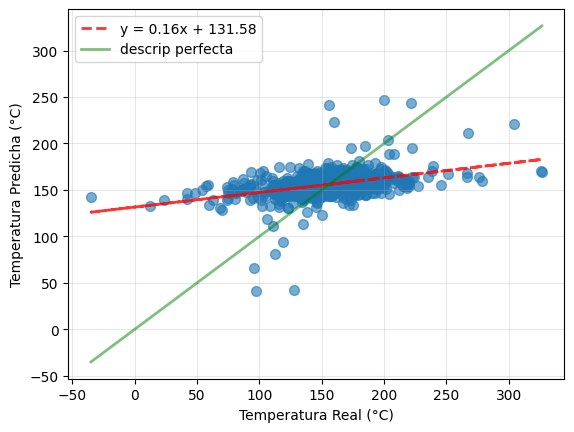

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(215)

def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo='Temperatura de Servicio °C, max'

# definir variables predictoras
variables_predictoras = [
        'Viscosidad del Aceite Base a 40°C. cSt',
        'Penetración de Cono a 25°C, 0.1mm', 
        'Punto de Gota, °C',
        'Punto de Soldadura Cuatro Bolas, kgf',
        'Grado NLGI Consistencia'
    ]


# pruebe
# expanded_data = simular_datos_vae(df, n_nuevos=1000)
# expanded_data = simular_datos_knn(df, n_nuevos=1000)
expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)

# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

In [29]:
print(f"MSE: train {mse_train} vs test {mse_test}")
print(f"R^2: train {r2_score_train} vs test {r2_score_test}")

MSE: train 937.2660919247614 vs test 656.498389230802
R^2: train 0.1570109592523663 vs test 0.2086197201341069


# 4. Ejercicios de simulacion y regresion
- Escriba una clase que le permita de manera expedita eligir cualquiera de los tres metodos
- Usted cree que la combinacion de 1 o mas metodos le pueda ser de ayuda? Combine varios metodos, puede usar `chatGPT` para hacer codigo en este punto
- Pruebe distintas combinaciones de variables, por ejemplo, preguntese que necesidad podria tener un cliente
- ... es decir, un cliente le puede solo interesar la viscosidad, investigue el mercado!!
- Intente mejorar estos modificando o agregando parametros
- Agregue mas graficas de diagnostico para ver la efectividad de la regresion lineal
- En cada uno de los casos, escriba lo que le va a explicar al socio formador y el motivo de su simulacion

# 5. Mejorando los datos
### 5.1 Un codificador caliente 🔥

La primera mejora que podemos hacer es las variables categoricas, no simplemente ponerlos como numeros enteros ordenados.


Ejercicios:
- Describa la utilidad de `OneHotEncoder`. (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- Las sifguientes lineas de codigo implementan este algoritmo reviselas y entiendalas
- Discuta si esta forma de transformar las variables categoricas puede ser util o no para el reto de Interlub
- Escriba una funcion (similar a la asignacion de numeros enteros ) que haga esta implementacion, domente dicha funcion
- Haga la generacion de datos y la regresion lineal y compare sus resultados con y sin esta implementacion


In [19]:
"""
from sklearn.preprocessing import OneHotEncoder

# cargar data_set
df = pd.read_csv("../../datos/datos_grasas_Tec_limpio_num.csv")
categorical_columns = ["color", "textura", "Espesante", "Aceite Base"]

ohe = OneHotEncoder(sparse_output=False, drop=None)
ohe_array = ohe.fit_transform(df[categorical_columns])
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
df_ohe = pd.DataFrame(ohe_array, columns=ohe_feature_names)
df_final = pd.concat([df.drop(columns=categorical_columns), df_ohe], axis=1)
# print(df_final.head())
df_final.to_csv("datos_one_hot.csv")

"""

'\nfrom sklearn.preprocessing import OneHotEncoder\n\n# cargar data_set\ndf = pd.read_csv("../../datos/datos_grasas_Tec_limpio_num.csv")\ncategorical_columns = ["color", "textura", "Espesante", "Aceite Base"]\n\nohe = OneHotEncoder(sparse_output=False, drop=None)\nohe_array = ohe.fit_transform(df[categorical_columns])\nohe_feature_names = ohe.get_feature_names_out(categorical_columns)\ndf_ohe = pd.DataFrame(ohe_array, columns=ohe_feature_names)\ndf_final = pd.concat([df.drop(columns=categorical_columns), df_ohe], axis=1)\n# print(df_final.head())\ndf_final.to_csv("datos_one_hot.csv")\n\n'

### 5.2. Descripciones en la base de datos con palabras 🗣️💬

La segunda mejora que podemos hacer es considerar las columnas que contiene informacion en palabras.

Ejercicios:
- Explique la funcion `CountVectorizer`. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

- Enumere sus parametros mas importantes y expliquelos
- Discuta si esta forma de transformar las variables descriptivas puede ser util o no para el reto de Interlub
- Con ayuda de `chatGPT` implemente `CountVectorizer`. Documente claramente sus prompts para que el profesor y el socio formador puedan entender que y el por que de lo que implemento
- Haga la generacion de datos y la regresion lineal y compare sus resultados con y sin esta implementacion


